# Assignment 3: Policy Gradients (DDPG and REINFORCE)

Name:Lianming Shi

ID:A99097650

## Background
This exercise requires you to solve various continous control problems in OpenAI-Gym.  

DDPG is policy gradient actor critic method for continous control which is off policy. It tackles the curse of dimensionality / loss of performance faced when discretizing a continous action domain. DDPG uses similiar "tricks" as DQN to improve the stability of training, including a replay buffer and target networks.

Furthermore, you will implement REINFORCE for discrete and continous environments, and as a bonus compare the sample efficiency and performance with DQN and DDPG.


### DDPG paper: https://arxiv.org/pdf/1509.02971.pdf

### Environments:

#### InvertedPendulum-v2 environment:
<img src="inverted_pendulum.png" width="300">

#### Pendulum-v0 environment:
<img src="pendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="half_cheetah.png" width="300">



### Setup environment for Actor Critic
- inline plotting
- gym
- directory for logging videos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
#environment
import gym
import os
import time
#pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn
from math import sqrt


logging_interval = 40
animate_interval = logging_interval * 5
logdir='./DDPG/'

### Set up gym environment
The code below does the following for you:
- Wrap environment, log videos, setup CUDA variables (if GPU is available)
- Record action and observation space dimensions
- Fix random seed for determinisitic training

In [2]:
VISUALIZE = False
SEED = 0
MAX_PATH_LENGTH = 500
NUM_EPISODES = 12000
GAMMA=0.99
BATCH_SIZE = 128

# Environments to be tested on
env_name = 'InvertedPendulum-v1'
#env_name = 'Pendulum-v0'
#env_name = 'HalfCheetah-v1' 

# wrap gym to save videos
env = gym.make(env_name)
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
env._max_episodes_steps = MAX_PATH_LENGTH

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")

# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

[2018-05-23 18:24:43,614] Making new env: InvertedPendulum-v1


### Demonstrate your understanding of the simulation:
For the environments mentioned above ('Pendulum-v0', 'HalfCheetah-v2', 'InvertedPendulum-v2'),
- describe the reward system
- describe the each state variable (observation space)
- describe the action space
- when is the environment considered "solved"?

Ans: 


### Implement an action normalization class:
To train across various environments, it is useful to normalize action inputs and outputs between [-1, 1]. This class should take in actions and implement forward and reverse functions to map actions between [-1, 1] and [action_space.low, action_space.high].

Using the following gym wrapper, implement this class.
- https://github.com/openai/gym/blob/78c416ef7bc829ce55b404b6604641ba0cf47d10/gym/core.py
- i.e. we are overriding the outputs scale of actions. 

In [3]:
class NormalizeAction(gym.ActionWrapper):
    def action(self, action):
        action = (action + 1) / 2  
        action *= (self.action_space.high - self.action_space.low)
        action += self.action_space.low
        return action

    def reverse_action(self, action):
        action -= self.action_space.low
        action /= (self.action_space.high - self.action_space.low)
        a
        ction = action * 2 - 1
        return actions


# DDPG

### Write a weight syncing function
In contrast to DQN, DDPG uses soft weight sychronization. At each time step following training, the actor and critic target network weights are updated to track the rollout networks. 
- target_network.weights <= target_network.weights \* (1 - tau) + source_network.weights \* (tau)

In [4]:
def weightSync(target_model, source_model, tau = 0.001):
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)

### Write a Replay class that includes all the functionality of a replay buffer
DDPG is an off policy actor-critic method and an identical replay buffer to that used for the previous assignment is applicable here as well (do not include the generate_minibatch method in your Replay class this time). Like before, your constructor for Replay should create an initial buffer of size 1000 when you instantiate it.

The replay buffer should kept to some maximum size (60000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). 

In [5]:
from collections import deque
import random

class Replay(object):
    def __init__(self, maxlen = 60000):
        self.maxlen = maxlen
        #self.data = deque(maxlen = self.maxlen)
        self.data=[]
        self.position=0

        self.initialize(init_length=1000, envir=env)
    def initialize(self,init_length=1000, envir=env):
        s = envir.reset()
        for i in range (init_length):
            #a = np.random.random(1)-np.random.random(1)
            a = env.action_space.sample()
            s1, r, done, _ = env.step(a)            
            self.add([np.reshape(s,(1,obs_dim)), np.reshape(a,(1,act_dim)), r, done, np.reshape(s1,(1,obs_dim))])
                        
            if done:
                s=envir.reset()
            else: 
                s = s1  
             
         
    def add(self, ep):
        self.data.append(ep)
        self.position = (self.position + 1) % self.maxlen       
        #self.data[self.position] = tuple(ep)
        
    def sample(self, nsamples):
        if nsamples > len(self.data):
            return random.sample(self.data, len(self.data))
        else:
            return random.sample(self.data, nsamples)

    def display(self):
        for x in self.data:
            print (x) 

### Write an Ornstein Uhlenbeck process class for exploration noise
The proccess is described here:
- https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process
- http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab

You should implement:
- a step / sample method
- reset method

Use theta = 0.15, mu = 0, sigma = 0.3, dt = 0.01

In [6]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, mu=np.zeros(act_dim), sigma=0.05, theta=.25, dimension=1e-2, x0=None,num_steps=12000):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dimension
        self.x0 = x0
        self.reset()

    def step(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

### Write a Deep Neural Network class that creates a dense network of a desired architecture for actor and critic networks


#### Actor
- input and hidden layer activation function: ReLU

- output activation function: Tanh

- hidden_state sizes: 400

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers

- weight initialization: normal distribution with small variance. 

#### Critic
- input and hidden layer activation function: ReLU

- output activation function: None

- hidden_state sizes: 300, 300 + action size

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers prior to the action input

- weight initialization: normal distribution with small variance.

Good baselines can be found in the paper.

In [7]:
# ----------------------------------------------------
# actor model, MLP
# ----------------------------------------------------
# 2 hidden layers, 400 units per layer, tanh output to bound outputs between -1 and 1

class critic(nn.Module):

    def __init__(self, state_size, action_size,output_size = 1):
        super(critic, self).__init__()

        self.state_dim = state_size
        self.action_dim = action_size
        h1_dim = 300
        h2_dim = 300

        self.fc1 = nn.Linear(self.state_dim,h1_dim)
        
        #self.bn1 = nn.BatchNorm1d(h1_dim)
        
        self.fc2 = nn.Linear(h1_dim + self.action_dim,h2_dim)
        
        self.fc3 = nn.Linear(h2_dim,output_size)


    def forward(self, sa):
        state, action =sa
        #s1 = F.relu(self.bn1(self.fc1(state)))
        s1 = F.relu(self.fc1(state))

        x = torch.cat((s1,action),dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class actor(nn.Module):

    def __init__(self, input_size, output_size):
        super(actor, self).__init__()

        self.state_dim = input_size
        self.action_dim = output_size
        h1_dim = 400
        h2_dim = 400

        self.fc1 = nn.Linear(self.state_dim,h1_dim)
        #self.bn1 = nn.BatchNorm1d(h1_dim)

        self.fc2 = nn.Linear(h1_dim,h2_dim)
        #self.bn2 = nn.BatchNorm1d(h2_dim)

        self.fc3 = nn.Linear(h2_dim,self.action_dim)

        
    def forward(self, state):
        #x = F.relu(self.bn1(self.fc1(state)))
        #x = F.relu(self.bn2(self.fc2(x)))
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = F.tanh(self.fc3(x))

        return action
    

### Define DDPG class to encapsulate definition, rollouts, and training

- gamma = 0.99

- actor_lr = 1e-4

- critic_lr = 1e-3

- critic l2 regularization = 1e-2

- noise decay

- noise class

- batch_size = 128

- optimizer: Adam

- loss (critic): mse

Furthermore, you can experiment with action versus parameter space noise. The standard implimentation works with action space noise, howeve parameter space noise has shown to produce excellent results.


In [8]:
class DDPG:
    def __init__(self, obs_dim, act_dim, critic_lr = 1e-3, actor_lr = 1e-4, gamma = GAMMA, batch_size = BATCH_SIZE):
        
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        
        # actor
        self.actor = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_perturbed = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target.load_state_dict(self.actor.state_dict())

        # critic
        self.critic = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target.load_state_dict(self.critic.state_dict())
        if use_cuda:
            self.actor.cuda()
            self.actor_target.cuda()
            self.critic.cuda()
            self.critic_target.cuda()
        # optimizers
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay=1e-2)
        
        # critic loss
        self.critic_loss = nn.MSELoss()
        
        # noise
        self.noise = OrnsteinUhlenbeckProcess(dimension = act_dim, num_steps = NUM_EPISODES)

        # replay buffer 
        self.replayBuffer = Replay()

        
    def action(self, s, noise, para):
        obs = torch.from_numpy(s).unsqueeze(0)
        inp = Variable(obs,requires_grad=False).type(FloatTensor)

        self.actor.eval()
        self.actor_perturbed.eval()

        if para is not None:
            a = self.actor_perturbed(inp).data[0].cpu().numpy() 
        else:
            a = self.actor(inp).data[0].cpu().numpy() 
        self.actor.train()

        if noise is not None:
            a = a + noise
        return a
    

    def perturb_actor_parameters(self, param_noise):
        """Apply parameter noise to actor model, for exploration"""
        hard_update(self.actor_perturbed, self.actor)
        params = self.actor_perturbed.state_dict()
        for name in params:
            if 'ln' in name: 
                pass 
            param = params[name]
            random = torch.randn(param.shape)
            if use_cuda:
                random = random.cuda()
            param += random * param_noise.current_stddev
    
    
    def train(self,training_data):
        # sample from Replay
        batch_s = np.vstack(training_data[:,0])
        batch_a = np.vstack(training_data[:,1])
        batch_s1 = np.vstack(training_data[:,4])
        batch_r = np.array(training_data[:,2]).astype("float")
        batch_done = np.array(training_data[:,3]).astype("float")
        
        s1 = Variable(torch.from_numpy(batch_s)).type(FloatTensor)
        a1 = Variable(torch.from_numpy(batch_a)).type(FloatTensor)
        r1 = Variable(torch.from_numpy(batch_r[:,None]),volatile = True).type(FloatTensor)
        s2 = Variable(torch.from_numpy(batch_s1), volatile = True).type(FloatTensor)
        d  = Variable(torch.from_numpy(1.0*batch_done)[:,None]).type(FloatTensor)

       
        a2 = self.actor_target.forward(s2)
        # ---------------------- optimize critic ----------------------

        next_val = self.critic_target((s2, a2)).detach()
        
        q_expected = r1 + self.gamma*next_val*(1.0-d)
        
        # y_pred = Q( s1, a1)
        q_predicted = self.critic((s1, a1))

        
        #print (y_predicted.volatile)
        #print (y_expected.volatile)

        # compute critic loss, and update the critic
        loss_critic = self.critic_loss(q_predicted, q_expected)
        self.optimizer_critic.zero_grad()
        #print (loss_critic.volatile)
        loss_critic.backward()
        self.optimizer_critic.step()

        # ---------------------- optimize actor ----------------------
        pred_a1 = self.actor.forward(s1)
        loss_actor = -1*self.critic.forward((s1, pred_a1))
        loss_actor = loss_actor.mean()
        #input()
        self.optimizer_actor.zero_grad()
        loss_actor.backward()
        #print (loss_actor.volatile)
        self.optimizer_actor.step()
        
        # sychronize target network with fast moving one
        weightSync(self.critic_target, self.critic)
        weightSync(self.actor_target, self.actor)
        

### Create an instance of your DDPG object
- Print network architectures, confirm they are correct

In [9]:
ddpg = DDPG(obs_dim = obs_dim, act_dim = act_dim)
print(ddpg.actor)
print(ddpg.critic)

actor(
  (fc1): Linear(in_features=4, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=1, bias=True)
)
critic(
  (fc1): Linear(in_features=4, out_features=300, bias=True)
  (fc2): Linear(in_features=301, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


### Train DDPG on different environments
Early stopping conditions:
- avg_val > 500 for "InvertedPendulum" 
- avg_val > -150 for "Pendulum" 
- avg_val > 1500 for "HalfCheetah" 



In [10]:
class AdaptiveParamNoiseSpec(object):
    def __init__(self, initial_stddev=0.1, desired_action_stddev=0.2, adaptation_coefficient=1.01):
        """
        Note that initial_stddev and current_stddev refer to std of parameter noise, 
        but desired_action_stddev refers to (as name notes) desired std in action space
        """
        self.initial_stddev = initial_stddev
        self.desired_action_stddev = desired_action_stddev
        self.adaptation_coefficient = adaptation_coefficient

        self.current_stddev = initial_stddev

    def adapt(self, distance):
        if distance > self.desired_action_stddev:
            # Decrease stddev.
            self.current_stddev /= self.adaptation_coefficient
        else:
            # Increase stddev.
            self.current_stddev *= self.adaptation_coefficient

    def get_stats(self):
        stats = {
            'param_noise_stddev': self.current_stddev,
        }
        return stats

    def __repr__(self):
        fmt = 'AdaptiveParamNoiseSpec(initial_stddev={}, desired_action_stddev={}, adaptation_coefficient={})'
        return fmt.format(self.initial_stddev, self.desired_action_stddev, self.adaptation_coefficient)

def ddpg_distance_metric(actions1, actions2):
    """
    Compute "distance" between actions taken by two policies at the same states
    Expects numpy arrays
    """
    diff = actions1-actions2
    mean_diff = np.mean(np.square(diff), axis=0)
    dist = sqrt(np.mean(mean_diff))
    return dist


def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
           target_param.data.copy_(param.data)


In [12]:
env = NormalizeAction(env) # remap action values for the environment
avg_val = 0

#for plotting
running_rewards_ddpg = []
step_list_ddpg = []
step_counter = 0

# set term_condition for early stopping according to environment being used
#term_condition = -150 # Pendulum
#term_condition = 500 # inverted Pendulum
term_condition = 1500 # half cheetah

param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.05,desired_action_stddev=0.3, adaptation_coefficient=1.05)

for itr in range(NUM_EPISODES):
    s=env.reset() # get initial state
    animate_this_episode = (itr % animate_interval == 0) and VISUALIZE
    total_reward=0
    ddpg.perturb_actor_parameters(param_noise)
    #actor_noise = OrnsteinUhlenbeckProcess(mu=np.zeros(act_dim))
    noise_counter=0
    while True:
        ddpg.noise.reset()
        if animate_this_episode:
                env.render('rgb_array')
                time.sleep(0.05)
        a = ddpg.action(s, ddpg.noise.step(),param_noise)
        #a = ddpg.action(s, None, param_noise)
        s1, r, done, _ = env.step(a)
        total_reward += r

        ddpg.replayBuffer.add([np.reshape(s,(1,obs_dim)), np.reshape(a,(1,act_dim)), r, done, np.reshape(s1,(1,obs_dim))])
        s = np.copy(s1)

        training_data = np.array(ddpg.replayBuffer.sample(BATCH_SIZE))
        ddpg.train(training_data)
        step_counter += 1
        noise_counter +=1
        if done:
            break
            
    if ddpg.replayBuffer.position-noise_counter > 0:
            noise_data=ddpg.replayBuffer.data[ddpg.replayBuffer.position-noise_counter:ddpg.replayBuffer.position]
    else:
           noise_data=ddpg.replayBuffer.data[ddpg.replayBuffer.position-noise_counter+60000:60000] \
            + ddpg.replayBuffer.data[0:ddpg.replayBuffer.position]
    noise_data=np.array(noise_data)
    noise_s = np.vstack(noise_data[:,0])
    noise_a = np.vstack(noise_data[:,1])

    perturbed_actions = noise_a
    unperturbed_actions = ddpg.action(noise_s, None, None)
    ddpg_dist = ddpg_distance_metric(perturbed_actions, unperturbed_actions)
    
    param_noise.adapt(ddpg_dist)
    
    if itr > 3 and avg_val > term_condition:
            break
    running_rewards_ddpg.append(total_reward) # return of this episode
    step_list_ddpg.append(step_counter)

    avg_val = avg_val * 0.95 + 0.05*running_rewards_ddpg[-1]
    print("Average value: {} for episode: {}".format(avg_val,itr))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Average value: 0.8500000000000001 for episode: 0
Average value: 1.2075 for episode: 1
Average value: 1.2971249999999999 for episode: 2
Average value: 1.3822687499999997 for episode: 3
Average value: 1.4631553124999996 for episode: 4
Average value: 1.5899975468749996 for episode: 5
Average value: 1.6604976695312494 for episode: 6
Average value: 1.7274727860546868 for episode: 7
Average value: 1.7910991467519524 for episode: 8
Average value: 1.8515441894143545 for episode: 9
Average value: 1.9089669799436368 for episode: 10
Average value: 1.9635186309464547 for episode: 11
Average value: 2.015342699399132 for episode: 12
Average value: 2.0645755644291754 for episode: 13
Average value: 2.1113467862077164 for episode: 14
Average value: 2.1557794468973306 for episode: 15
Average value: 2.197990474552464 for episode: 16
Average value: 2.2380909508248403 for episode: 17
Average value: 2.276186403283598 for episode: 18
Average value: 2.312377083119418 for episode: 19
Average value: 2.346758228

Average value: 3.572936930462881 for episode: 168
Average value: 3.494290083939737 for episode: 169
Average value: 3.5695755797427497 for episode: 170
Average value: 3.4910968007556122 for episode: 171
Average value: 3.4665419607178314 for episode: 172
Average value: 3.4432148626819394 for episode: 173
Average value: 3.421054119547842 for episode: 174
Average value: 3.35000141357045 for episode: 175
Average value: 3.4325013428919275 for episode: 176
Average value: 3.360876275747331 for episode: 177
Average value: 3.442832461959964 for episode: 178
Average value: 3.470690838861966 for episode: 179
Average value: 3.4471562969188674 for episode: 180
Average value: 3.524798482072924 for episode: 181
Average value: 3.4985585579692775 for episode: 182
Average value: 3.4736306300708133 for episode: 183
Average value: 3.4499490985672723 for episode: 184
Average value: 3.4274516436389084 for episode: 185
Average value: 3.4060790614569627 for episode: 186
Average value: 3.4857751083841144 for ep

Average value: 15.276327605886543 for episode: 331
Average value: 15.012511225592215 for episode: 332
Average value: 14.661885664312605 for episode: 333
Average value: 14.278791381096973 for episode: 334
Average value: 16.56485181204212 for episode: 335
Average value: 18.036609221440013 for episode: 336
Average value: 17.484778760368012 for episode: 337
Average value: 19.36053982234961 for episode: 338
Average value: 19.242512831232133 for episode: 339
Average value: 18.930387189670526 for episode: 340
Average value: 18.633867830186997 for episode: 341
Average value: 18.602174438677643 for episode: 342
Average value: 18.572065716743758 for episode: 343
Average value: 18.54346243090657 for episode: 344
Average value: 19.016289309361238 for episode: 345
Average value: 19.265474843893173 for episode: 346
Average value: 19.852201101698515 for episode: 347
Average value: 19.259591046613586 for episode: 348
Average value: 18.596611494282907 for episode: 349
Average value: 19.36678091956876 f

Average value: 106.60639415056004 for episode: 493
Average value: 105.87607444303202 for episode: 494
Average value: 104.03227072088042 for episode: 495
Average value: 101.0806571848364 for episode: 496
Average value: 98.77662432559457 for episode: 497
Average value: 95.93779310931482 for episode: 498
Average value: 95.64090345384908 for episode: 499
Average value: 99.05885828115662 for episode: 500
Average value: 96.90591536709879 for episode: 501
Average value: 94.56061959874384 for episode: 502
Average value: 92.68258861880663 for episode: 503
Average value: 92.8984591878663 for episode: 504
Average value: 90.10353622847298 for episode: 505
Average value: 91.19835941704932 for episode: 506
Average value: 89.08844144619685 for episode: 507
Average value: 87.584019373887 for episode: 508
Average value: 86.65481840519266 for episode: 509
Average value: 84.92207748493301 for episode: 510
Average value: 83.22597361068635 for episode: 511
Average value: 81.11467493015203 for episode: 512


Average value: 122.2411112907193 for episode: 656
Average value: 124.27905572618334 for episode: 657
Average value: 123.01510293987417 for episode: 658
Average value: 123.51434779288046 for episode: 659
Average value: 122.88863040323642 for episode: 660
Average value: 124.1441988830746 for episode: 661
Average value: 122.23698893892086 for episode: 662
Average value: 121.1251394919748 for episode: 663
Average value: 127.56888251737607 for episode: 664
Average value: 124.04043839150725 for episode: 665
Average value: 134.03841647193187 for episode: 666
Average value: 136.23649564833528 for episode: 667
Average value: 158.9246708659185 for episode: 668
Average value: 153.72843732262257 for episode: 669
Average value: 149.09201545649145 for episode: 670
Average value: 146.23741468366686 for episode: 671
Average value: 143.4255439494835 for episode: 672
Average value: 143.80426675200934 for episode: 673
Average value: 147.66405341440887 for episode: 674
Average value: 146.08085074368844 fo

Average value: 978.7561742089385 for episode: 819
Average value: 979.8183654984916 for episode: 820
Average value: 980.827447223567 for episode: 821
Average value: 981.7860748623885 for episode: 822
Average value: 982.6967711192691 for episode: 823
Average value: 983.5619325633056 for episode: 824
Average value: 984.3838359351403 for episode: 825
Average value: 985.1646441383832 for episode: 826
Average value: 985.906411931464 for episode: 827
Average value: 986.6110913348908 for episode: 828
Average value: 987.2805367681462 for episode: 829
Average value: 987.9165099297389 for episode: 830


KeyboardInterrupt: 

## Plot rewards over multiple training runs 
This is provided to generate and plot results for you.

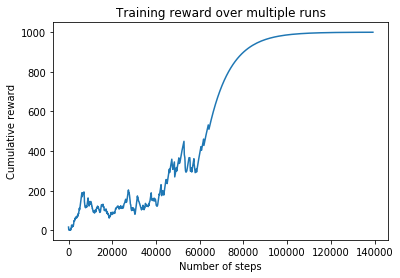

In [13]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
step_list_ddpg = np.array(step_list_ddpg)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

In [ ]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

## ddpg inverted-pendulum

In [ ]:
running_rewards_ddpg1=np.load('ddpg_invpendulum_reward.npy')
step_list_ddpg1=np.load('ddpg_invpendulum_step.npy')
plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg1),20)
step_list_ddpg = np.array(step_list_ddpg1)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

## ddpg pendulum

In [ ]:
running_rewards_ddpg2=np.load('ddpg_pendulum_reward.npy')
step_list_ddpg2=np.load('ddpg_pendulum_step.npy')
plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg2),20)
step_list_ddpg = np.array(step_list_ddpg2)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

## ddpg halfcheetah

In [ ]:
running_rewards_ddpg3=np.load('ddpg_cheetah_reward.npy')
step_list_ddpg3=np.load('ddpg_cheetah_step.npy')
plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg3),20)
step_list_ddpg = np.array(step_list_ddpg3)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

# REINFORCE

In this section you will implement REINFORCE, with modifications for batch training. It will be for use on both discrete and continous action spaces.

## Policy Parametrization

Define a MLP which outputs a distribution over the action preferences given input state. For the discrete case, the MLP outputs the likelihood of each action (softmax) while for the continuous case, the output is the mean and standard deviation parametrizing the normal distribution from which the action is sampled.



In [ ]:
# ----------------------------------------------------
# Policy parametrizing model, MLP
# ----------------------------------------------------
# 1 or 2 hidden layers with a small number of units per layer (similar to DQN)
# use ReLU for hidden layer activations
# softmax as activation for output if discrete actions, linear for continuous control
# for the continuous case, output_dim=2*act_dim (each act_dim gets a mean and std_dev)

class mlp(nn.Module):
    def __init__(self, Dim_state, num_outputs, disct):
        super(mlp, self).__init__()
        self.disct = disct
        if self.disct == True:
            self.fc1 = nn.Linear(Dim_state, 50)
            self.fc2 = nn.Linear(50, 50)
            self.fc3 = nn.Linear(50, num_outputs)
        else:
            self.fc1 = nn.Linear(Dim_state, 50)
            self.fc2 = nn.Linear(50, 50)
            self.f3 = nn.Linear(50, num_outputs)   
            self.f3_ = nn.Linear(50, num_outputs)     


    def forward(self, x):
        if self.disct == True:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.softmax(x, dim=1)
        else: 
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            mu=self.f3(x)
            sigma=self.f3_(x)
            return [mu,sigma] 

Define a function that samples an action from the policy distribtion parameters obtained as output of the MLP. The function should return the action and the log-probability (log_odds) of taking that action. 

In [ ]:
def sample_action(logit, disct):
    # logit is the output of the softmax/linear layer
    # discrete is a flag for the environment type
    # Hint: use Categorical and Normal from torch.distributions to sample action and get the log-probability
    # Note that log_probability in this case translates to ln(\pi(a|s)) 
    if disct == True:
        action_distribution=torch.distributions.Categorical(logit)
        action = action_distribution.sample()
        log_odds = action_distribution.log_prob(action)
    else : # continuous 
        action_distribution = torch.distributions.normal.Normal(logit[0],F.softplus(logit[1]))
        action = action_distribution.sample()
        log_odds = action_distribution.log_prob(action)
    return action, log_odds

Create a function update_policy that defines the loss function and updates the MLP according to the REINFORCE update rule (ref. slide 24 of Lec 7 or page 330 of Sutton and Barto (2018)). The update algorithm to be used below is slightly different: instead of updating the network at every time-step, we take the gradient of the loss averaged over a batch of timesteps (this is to make SGD more stable). We also use a baseline to reduce variance. 

The discount factor is set as 1 here. 


In [ ]:
# calculated as "reward to go"
def rewardtogo(rewards, gamma =1):
    r2g = []
    acc_r = 0
    for r in reversed(rewards):
        acc_r = acc_r * gamma + r
        r2g.append(acc_r)
    return r2g[::-1]

def update_policy(paths, net):
    # paths: a list of paths (complete episodes, used to calculate return at each time step)
    # net: MLP object
    
    num_paths = len(paths)
    rew_cums = []
    log_odds = []

    
    for path in paths:
        # rew_cums should record return at each time step for each path
        rew_cums += rewardtogo(path['reward'])
        # log_odds should record log_odds obtained at each timestep of path
        log_odds += path['log_odds']
        # calculated as "reward to go" 

    # make log_odds, rew_cums each a vector
    rewards = np.array(rew_cums)
    log_odds = np.array(log_odds)
    rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5) # create baseline
    # calculate policy loss and average over paths
    policy_loss = -rewards.dot(log_odds)/ num_paths
    
    # take optimizer step
    optimizer.zero_grad()
    policy_loss.sum().backward()
    optimizer.step() 
    
    

Set up environment and instantiate objects. Your algorithm is to be tested on one discrete and two continuous environments. 



In [ ]:
# Select Environment

#discrete environment:
#env_name='CartPole-v0'

#continous environments:
env_name='InvertedPendulum-v1'
#env_name = 'HalfCheetah-v1'


# Make the gym environment
env = gym.make(env_name)
visualize = True
animate=visualize
learning_rate = 1e-3

max_path_length=None
min_timesteps_per_batch=2000

# Set random seeds
seed=0
torch.manual_seed(seed)
np.random.seed(seed)

# Saving parameters
logdir='./REINFORCE/'

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
if visualize:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)
env._max_episodes_steps = min_timesteps_per_batch


# Is this env continuous, or discrete?
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Get observation and action space dimensions
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

# Make network object (remember to pass in appropriate flags for the type of action space in use)
# net = mlp(*args)

net = mlp(Dim_state = obs_dim, num_outputs = act_dim, disct = discrete).type(FloatTensor)

# Make optimizer
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)


## Run REINFORCE

Run REINFORCE for CartPole, InvertedPendulum, and HalfCheetah. 

In [ ]:
n_iter = 1000 
min_timesteps_per_batch = 2000  # sets the batch size for updating network
avg_reward = 0
avg_rewards = []
step_list_reinforce = []
total_steps = 0
episodes = 0

for itr in range(n_iter): # loop for number of optimization steps
    paths = []
    steps = 0
    
    while True: # loop to get enough timesteps in this batch --> if episode ends this loop will restart till steps reaches limit
        ob = env.reset()   
        animate_this_episode = (itr % animate_interval == 0) and visualize
        obs, acs, rews, log_odds = [], [], [], [] 
        obs.append(ob)

        while True: # loop for episode inside batch
            if animate_this_episode:
                env.render()
                time.sleep(0.05)
            # get parametrized policy distribution from net using current state ob
            net.eval()
            var_ob = Variable(torch.unsqueeze(FloatTensor(ob),0), requires_grad=False)
            distribution_parameters = net(var_ob)
            net.train()
            # sample action and get log-probability (log_odds) from distribution
            cuda_tensor_ac, log_odd= sample_action(logit = distribution_parameters , disct = discrete)
            ac = cuda_tensor_ac.data[0].cpu().numpy()
            # step environment, record reward, next state
            ob, rew, done, _ = env.step(ac)
            # append to obs, acs, rewards, log_odds
            obs.append(ob)
            acs.append(ac)
            rews.append(rew)
            log_odds.append(log_odd)
            
            # if done, restart episode till min_timesteps_per_batch is reached     
            steps += 1
            
            if done:
                episodes = episodes + 1
                break
                
        path = {"observation" : obs, 
                "reward" : np.array(rews), 
                "action" : (acs),
                "log_odds" : log_odds}
        
        paths.append(path)
        
        if steps > min_timesteps_per_batch:
            break 

    update_policy(paths, net)  # use all complete episodes (a batch of timesteps) recorded in this itr to update net

    if itr == 0:
        avg_reward = path['reward'].sum()
    else:
        avg_reward = avg_reward * 0.95 + 0.05 * path['reward'].sum()
    
    if avg_reward > 500:
        break
    
    total_steps += steps
    print(avg_reward,end='\r')
    avg_rewards.append(avg_reward)
    step_list_reinforce.append(total_steps)
    if itr % logging_interval == 0:
        print('Average reward: {}'.format(avg_reward))
   
      
env.close()
#np.save('reinforce_cheetah_reward.npy', avg_rewards)
#np.save('reinforce_cheetah_step.npy', step_list_reinforce)
plt.plot(avg_rewards)
plt.title('Training reward for <env> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

In [ ]:
np.save('reinforce_invpendulum_reward.npy', avg_rewards)
np.save('reinforce_invpendulum_step.npy', step_list_reinforce)

In [ ]:
plt.plot(avg_rewards)
plt.title('Training reward for <inv> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

# BONUS (15% extra)

Compare average returns for CartPole (discrete action space) when using REINFORCE and DQN. Since in REINFORCE we update the network after a set number of steps instead of after every episode, plot the average rewards as a function of steps rather than episodes for both DQN and REINFORCE. You will need to make minor edits to your DQN code from the previous assignment to record average returns as a function of time_steps.

Similarly, compare REINFORCE with DDPG on InvertedPendulum and HalfCheetah using steps for the x-axis.

You may use the example code provided below as a reference for the graphs.


In [ ]:
 # import your DQN and format your average returns as defined above


# DQN and Reinforce

In [ ]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from __future__ import print_function
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
batch_size = 1000
learning_rate = 0.01                   # learning rate
env = gym.make('CartPole-v0')   
#env = env.unwrapped
action_size = env.action_space.n  
state_size = env.observation_space.shape[0]   
hidden_size = 64
alpha_decay = 0.1


In [ ]:
class Net(nn.Module):
    def __init__(self,hidden_size,state_size, action_size):
        super(Net, self).__init__()
        nn.Module.__init__(self)
        self.dense1 = nn.Linear(state_size, hidden_size)
        self.out = nn.Linear(hidden_size, action_size)
     #   self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate,weight_decay=alpha_decay)    
     #   self.loss_func = nn.MSELoss()  

    def forward(self, x):
        x = self.dense1(x)
        x = F.tanh(x)
        actions_value = self.out(x)
        return actions_value
    
class QNetwork(object):
    def __init__(self,learning_rate, state_size, action_size, hidden_size, alpha_decay):
        self.hidden_size=hidden_size
        self.state_size=state_size
        self.action_size=action_size
        self.alpha_decay=alpha_decay
        self.net = Net(self.hidden_size,self.state_size,self.action_size)
        self.LR = learning_rate    
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.LR) 
        self.loss_func = nn.MSELoss() 
        
        
    def learn(self, current_q_value, expected_q_values):
        self.optimizer.zero_grad()

        loss = self.loss_func(current_q_value, expected_q_values)
        loss.backward()
        
        for param in self.net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    

In [ ]:
class Replay():
# Replay should also have an initialize method which creates a minimum buffer for 
# the initial episodes to generate minibatches.  
    def __init__(self, max_size):
        self.memory_counter = 0    
        self.capacity = max_size
        self.memory = []
        self.gamma=0.99
        
    def initialize(self,init_length, envir=env):
        state = envir.reset()
        for i in range (init_length):
            action = LongTensor([[env.action_space.sample()]])
            next_state, reward, done, _ = envir.step(action.data[0][0].cpu().numpy())
            
            self.push((FloatTensor([state]),
                     action,  
                     FloatTensor([next_state]),
                     FloatTensor([reward]),done))
            if done:
                state=envir.reset()
            else: 
                state = next_state            
        
    def push(self, transition):
        self.memory.append(transition)
        self.memory_counter += 1

        if len(self.memory) > self.capacity:
            del self.memory[0]


    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def generate_minibatch(self, DQN, targetDQN, BATCH_SIZE):
        transitions = self.sample(BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)
        batch_state = Variable(torch.cat( batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        
        # current Q values are estimated by NN for all actions
        current_q_values = DQN.net.forward(batch_state).gather(1, batch_action)
        
        # expected Q values are estimated from actions which gives maximum Q value
        max_next_q_values= targetDQN.net.forward(batch_next_state).detach().max(1)[0]
         
        #if done:     y = reward
        #if not done: y = reward + gamma*Qmax
        choose=np.invert(np.array(batch_done))*max_next_q_values.data.cpu().numpy()
        
        expected_q_values = batch_reward + (self.gamma * Variable(FloatTensor(choose)))
        expected_q_values = FloatTensor(expected_q_values.data.cpu().numpy()[:,None]) 
        return  current_q_values,expected_q_values 
    
        # loss is measured from error between current and newly expected Q values
        #loss = F.mse_loss(current_q_values, expected_q_values)
        # backpropagation of loss to NN
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()  

In [ ]:
DQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
targetDQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)

targetDQN.net.load_state_dict(DQN.net.state_dict())
#targetDQN.net.dense1.weight=DQN.net.dense1.weight

# set targetDQN weights to DQN weights
# targetDQN.model.weights = DQN.model.weights (syntax given here is for representation purpose only)

## Initialize Replay Buffer
###################################
## Populate the initial experience buffer
###################################

replay = Replay(max_size=10000)
replay.initialize(init_length=1000, envir=env)
if use_cuda:
    DQN.net.cuda()
    targetDQN.net.cuda()

In [ ]:
# Runtime parameters
num_episodes = 1000            # max number of episodes to learn from
gamma = 0.99                   # future reward discount
max_steps = 500                # cut off simulation after this many steps
# Exploration parameters
min_epsilon = 0.01             # minimum exploration probability
decay_rate = 5/num_episodes    # exponential decay rate for exploration prob
returns = np.zeros(num_episodes)
learn_step_counter=0
avg_reward = 0
avg_rewards=[]

for ep in range(0, num_episodes):
    paths=[]
    steps=0
    while True:
        total_reward=0
        # --> start episode 
        state = env.reset()
        epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
        rews=[]
        while True:

            # explore/exploit and get action using DQN
            if random.random() > epsilon:
                action = DQN.net.forward(Variable(FloatTensor([state]),volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)

            else:
                action = LongTensor([[random.randrange(2)]])
            next_state, reward, done, _ = env.step(action.data[0][0].cpu().numpy())

            total_reward=total_reward+reward
            # perform action and record new_state, action, reward
            # populate Replay experience buffer
            replay.push((FloatTensor([state]),action,FloatTensor([next_state]),FloatTensor([reward]),done))

            state = next_state
            rews.append(reward)
            steps+=1
            if done:
                #print(ep,   round(np.mean(returns[ep-99:ep]),0),end='\r')
                break
        path={'reward':np.array(rews)}
        paths.append(path)
        if steps > 2000:
            break
    # I modified the output of the generate_minibatch so that I can directly use these two q-values to 
    # calculate loss and do optimization 
    current_q_value, expected_q_values = replay.generate_minibatch(DQN, targetDQN, batch_size)
    DQN.learn(current_q_value,expected_q_values)
    returns[ep] = total_reward
    # set targetDQN weights to DQN weights
    # update DQN (run one epoch of training per episode with generated minibatch of states and qvalues)
    targetDQN.net.load_state_dict(DQN.net.state_dict())
    if ep==0:
        avg_reward = path['reward'].sum()
    else:
        avg_reward = avg_reward * 0.95 + 0.05 * path['reward'].sum()
    total_steps+=steps
    avg_rewards.append(avg_reward)
    step_list_DQN.append(total_steps)

    if ep % 100 == 0:
        print('Average reward: {}'.format(avg_reward))



In [ ]:
plt.plot(avg_rewards)
plt.title('Training reward for <env> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

In [ ]:
#np.save('dqn.npy', avg_rewards)

In [ ]:
running_rewards_DQN=np.load('DQN_reward.npy')
step_list_DQN=np.load('DQN_step.npy')


plt.plot(step_list_reinforce, avg_rewards) 
plt.plot(step_list_DQN, running_rewards_DQN)
plt.title('Training reward for <inverted pendulum> over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
#plt.legend(['DDPG', 'REINFORCE']) 
plt.legend(['DQN', 'REINFORCE'])

# DDPG and Reinforce

## Half Cheetah

In [ ]:
avg_rewards=np.load('reinforce_cheetah_reward.npy')
step_list_reinforce=np.load('reinforce_cheetah_step.npy')

plt.figure()

out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg3),20)
plt.plot(step_list_ddpg3, out) 
plt.plot(step_list_reinforce, avg_rewards)
#plt.plot(step_list_DQN, out)
plt.title('Training reward for <cheetah> over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DDPG', 'REINFORCE']) 
#plt.legend(['DQN', 'REINFORCE'])


plt.show()


## Inverted Pendulum

In [ ]:
plt.figure()

out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg1),20)
plt.plot(step_list_ddpg1, out) 
plt.plot(step_list_reinforce, avg_rewards)
#plt.plot(step_list_DQN, out)
plt.title('Training reward for <inverted pendulum> over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DDPG', 'REINFORCE']) 
#plt.legend(['DQN', 'REINFORCE'])


plt.show()